In [7]:
# !pip3 install torch torchvision torchaudio
# !pip freeze >> requirements.txt

Датасет :https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz.\
Задача : обучить классификатор цветных изображений с помощью свёрточной (не полносвязной архитектуры) сети искусственных нейронов.

Структура датасета:
1. batches.meta.txt
2. data_batch_1.bin
3. data_batch_2.bin
4. data_batch_3.bin
5. data_batch_4.bin
6. data_batch_5.bin
7. readme.html
8. test_batch.bin\
data_batch_1.bin и т.д. содержат обучающие примеры, а test_batch.bin - тестовые примеры. batches.meta.txt - метаданные.

Для тренировки сети будет использоваться общедоступный набор данных CIFAR10. 
Классы: «самолет», «автомобиль», «птица», 
        «кошка», «олень», «собака», «лягушка», 
        «лошадь», «корабль», «грузовик». 
Изображения в CIFAR10 3-канальные цветные размером 32x32 пикселя.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Вывод тренировочных образов для проверки:

Преобразование данных \
\
ToTensor() преобразует изображение из формата PIL Image или массива NumPy в тензор PyTorch.

Normalize() нормализует тензор, используя указанные средние и стандартные отклонения для каждого канала (средние и стандартные отклонения устанавливаются в (0,5, 0,5, 0,5) для каждого цветового канала).

Обучающий набор данных:

– root=./data является прямым путем к папке набора данных\
– train=True является параметром, позволяющим определить, что набор данных является обучающим\
– download=True, если файл или папка не существует, создает новый и загружает\
– torch.utils.data.Dataset создает загрузчик данных для обработки блоков и перемешивания обучающего набора данных\
– batch_size=4 устанавливает размер блока равным 4\
– shuffle=True перемешивает обучающие данные случайно\
– num_workers=2 указывает количество рабочих потоков для загрузки данных\
\
Так же указываются классы в датасете, которых всего 10

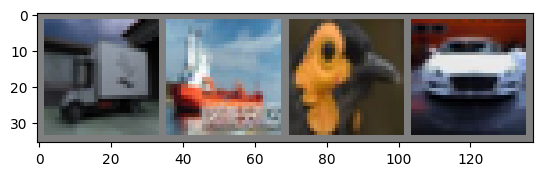

truck  ship  bird   car


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)

for images, labels in trainloader:
    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
    break

Чтобы создать нейронную сеть, нужно понять, как она функционирует. Это простейшая сеть прямой связи. Она принимает вводные данные, пропускает их через ряд слоев и в конце выдает выходные данные.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

Слои модели:
1. Свёрточный слой conv1 - nn.Conv2d(3,6,5) - Принимает входной тензор с 3 каналами (предположительно, RGB) и применяет 6 фильтров размером 5x5. Это создает 6 карт признаков.
2. Пуллинговый слой pool - ''nn.MaxPool2d(2,2) -  После каждого сверточного слоя используется слой максимального пулинга размером 2x2, что уменьшает размер карт признаков вдвое.
3. Свёрточный слой conv2 - nn.Conv2d(6,16,5) - Принимает 6 входных карт признаков (от предыдущего сверточного слоя) и применяет 16 фильтров размером 5x5. Это увеличивает глубину карт признаков.
4. Полносвязные слои fc1, fc2, fc3 -
   1. nn.Linear(16 * 5 * 5, 120) - После второго сверточного слоя данные "разворачиваются" (flatten) в вектор и проходят через первый полносвязный слой с 120 нейронами.
   2. nn.Linear(120, 84) - Второй полносвязный слой с 84 нейронами.
   3. nn.Linear(84, 10) - Выходной полносвязный слой с 10 нейронами, что соответствует 10 классам в CIFAR-10.
  

Определение функции потерь и оптимизатора:

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Тренировка сети на тренировочных данных

In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.178
[1,  4000] loss: 1.857
[1,  6000] loss: 1.720
[1,  8000] loss: 1.590
[1, 10000] loss: 1.547
[1, 12000] loss: 1.527
[2,  2000] loss: 1.445
[2,  4000] loss: 1.425
[2,  6000] loss: 1.395
[2,  8000] loss: 1.368
[2, 10000] loss: 1.358
[2, 12000] loss: 1.341
Finished Training


Сохранение обученной модели

In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

Тестирование сети на тестовых данных

Проверка происходит путем, предсказания метки класса, которую выводит нейронная сеть, и проверки ее на предмет истинности. Если прогноз верен, то образец добавляется в список правильных прогнозов.

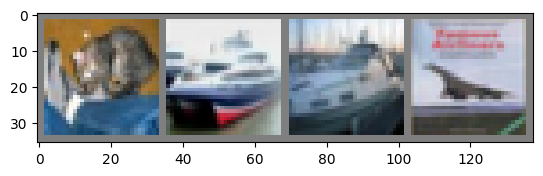

GroundTruth:    cat  ship  ship plane


In [15]:
# get some random test images
for images, labels in testloader:
    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    break  # прерывание цикла после первой итерации, чтобы не продолжать бесконечно

In [17]:
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship



Теперь посмотрим, как сеть работает во всём наборе данных.

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %



Теперь посмотрим, наксолько точно сеть может определять конкретный класс:

In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 54 %
Accuracy of  bird : 30 %
Accuracy of   cat : 34 %
Accuracy of  deer : 39 %
Accuracy of   dog : 49 %
Accuracy of  frog : 67 %
Accuracy of horse : 61 %
Accuracy of  ship : 57 %
Accuracy of truck : 75 %


Отсюда видно, что наиболее распознаваемыми классами являются:
1. Грузовики
2. Лягушки
3. Самолёты
4. Корабли и т.д.


Подводя итоги: произошло обучение нейронной сети, для CIFAR-10. Как минимум, она будет полена для обхода Google-капч.

Данная модель уже обучена и может использоваться для решения различных задач. Она сохранена в файле `cifar_net.pth` для её дальнейшего использования отдельно.